# Training Parameterized Quantum Circuits

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/machine-learning/training-quantum-circuits

## Introduction

The goal of training a quantum circuit model is to minimize a cost/loss function (objective function) with respect to the parameter vector $\vec{\theta}$. This equates to minimizing the expectation value.

## Gradients

Gradient descent is when we have access to the gradient of our cost function and we use it to evaluate the direction of steepest descent (which is what we want for minimizing the cost function) to then adjust our current parameter values. We do this until we converge to a local minimum. We can show how to do that in Qiskit.

First, we need to define our parameterized state as shown below.

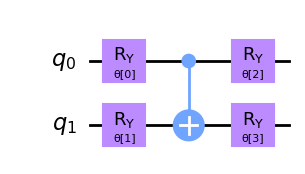

In [1]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

Next, we define a Hamiltonian (cost function) for which we are interested in minimizing. We'll use $\hat{H} = \hat{Z} \bigotimes \hat{Z}$. So we combine our parameterized state and measure the (average) observable defined by the Hamiltonian.

In [8]:
from qiskit.opflow import StateFn, PauliExpectation
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_41826/1302685014.py:5: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_41826/1302685014.py:5: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_41826/1302685014.py:6: DeprecationWarning: The class ``qiskit.opflow.expectations.p

The function below will evaluate the expectation value.

In [9]:
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_41826/2366752076.py:6: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_41826/2366752076.py:10: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  sampler = CircuitSampler(quantum_instance)


### Finite difference gradients

One of the simplest ways to approximate gradients is the finite difference scheme which works independently of a function's inner (possibly very complex) structure. This is basically the definition of the derivative where we evaluate the function just a tiny distance away from our current parameter value and then take the average.

$gradient of f(\vec{\theta}) = \frac{1}{2\epsilon}(f(\vec{\theta}) + \epsilon - f(\vec{\theta}) - \epsilon)$

This can be done using Qiskit's Gradient class. The finite different gradient can be volatile and noisy compared to the exact formula for the gradient and sometimes the noise can cause it to point in the opposite direction of the true gradient.

### Analytic gradients

Analytics gradients evaluate the analytic formula for the gradient. While this can be fairly difficult, there is research supporting an easy formula to do this called the parameter shift rule. For a simple circuit containing of only Pauli rotations (without any coefficients), this rule says:

$\frac{\delta f}{\delta \theta_i} = \frac{f(\vec{\theta} + \frac{\pi}{2}\vec{e_i}) - f(\vec{\theta} + \frac{\pi}{2}\vec{e_i})}{2}$

This can be done using Qiskit's Gradient class where this is done by default.

### Natural gradients

Gradients use the Euclidean distance between successive parameter values whereas natural gradients use fidelity distance ($d = || \bra{\psi(\vec{\theta_n})}\ket{\psi(\vec{\theta_{n+1}})}||^2$). This is preferred because it takes into account the sensitivity of the model in regards to each parameter versus assuming the same update size for each parameter. There's a formula called the Quantum Fisher Information that is a component of the Quantum Natural Gradient (exact details can be found on the qiskit documentation webpage) that allows us to transform the steepest descent in the Euclidean parameter space to the steepest descent in the model space.

![image qfi](./qfi.svg)


The natural gradient can be computed using Qiskit's NaturalGradient class and it produces different gradient values compared to the Gradient class. In general, the natural gradient helps convergence get reached faster but at the cost of needing to evaluate many more quantum circuits.

### Simultaneous Perturbation Stochastic Approximation

Given our function $f(\vec{\theta})$, evaluating the gradient means calculating the partial derivative to each parameter which would be 2N function evaluations for N parameters (using shift rule or finite difference scheme where 2 evaluations are needed for each parameter).

The SPSA is an optimization technique that randomly samples the gradient to reduce the number of evaluations. This will cause some jumping around but will converge (basically following the gradient descent curve) but with a fraction of the cost. This same idea can also be applied to the natural gradient as well where we sample from the quantum Fisher information.

The gradient descent and natural gradient have linear and quadratic costs in terms of the number of parameters but the SPSA and QNSPSA are constant which makes them efficient algorithms.

### Training in practice

In practice, circuit evaluations are expensive and thus people often resort to using SPSA. To further improve convergence, the learning rate is optimized as well. Instead of using a constant learning rate, an exponentially decreasing one does a better job at making progress very quickly and then fine-tuning the updates when near convergence. This works well if you know what your loss function looks like. Qiskit will automatically calibrate the learning rate if one is not specified.

## Limitations

In general, the above techniques all work pretty well for a _small_ model where the Qiskit documentation was working with a quantum circuit model that only had 4 parameters. We can explore how well this works for larger quantum model circuits by looking at the variance of gradients; if the variance is small, we don't have enough information to update the parameters.

### Exponentially vanishing gradients (barren plateaus)

For a general parameterized quantum circuit, we can look at the relationship between the circuit size (number of qubits) and the variance of a sample of the evaluations of the (analytics) gradients at a bunch of random initial points. Overall, we see that the variance shrinks exponentially with the circuit size so the larger the circuit, the flatter our loss landscape looks which makes it hard for us to know which direction to go to find the minimum. This problem is known as the "barren plateau" or "exponentially vanishing gradients" challenge.

We can also test this trend for a less deep circuit, a parameterized quantum circuit that only has 1 repeat for the rotation/entanglement layers. However, we see the exact same trend line where the variance shrinks exponentially.

Another thing tested is global operators versus local operators. Global operators act on the entire circuit (such as a Z gate applied to every qubit) whereas local operators act on only a few qubits (such as a Z gate applied to the first 2 qubits and everything else gets the identity operator). This also still gives us barren plateaus.

Lastly, we can try all things at once so a short depth circuit (1 layer) with local operators and we see that the variance no longer shrinks exponentially. However, these circuits seem comparable to a _small_ model circuit becuase of the local operators and they are simple due to the short depth, which makes them easy to simulate classically so they don't provide any advantage over classical models.

The last modification is to train a circuit one layer at a time; so start with a single layer of rotations using local operators and optimize for the best set of parameters and then make those fixed. Then, add another layer and optimize and fix those. Continue doing this for however many layers. Testing this does show that this does potentially avoid the barren plateaus problem.

<font color="red">Question/Comment: </font>The last suggestion makes sense and its intersting to think of it in comparison to neural networks and building/training those one layer at a time. In NN, the early layers are good at identifying features (such as contours, lines, etc in images) whereas the later layers use those higher-dimensional features to get an answer. So if quantum model circuits are sort of similar, I wonder how this training procedure will perform if you train it with the expectation that 1 layer should be optimized for the solution, then fix those parameters and add in another layer. Would this eliminate the possibility that the quantum circuit can work out the "features" of the inputs?